# Let's look at the results if running the alphafold in silico predictor on enh1 vs consensus model

In [1]:
import json
import nomelt.thermo_estimation.rosetta
import os

from Bio.PDB import *
parser = PDBParser()
import nglview as nv
import ipywidgets

import matplotlib.pyplot as plt
import numpy as np

[2023-08-11 10:26:45,405] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-08-11 10:26:47.394545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 10:26:47.692816: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
with open('../scripts/proof_of_principle/enh1_vs_consensus_in_silico_estimator_out.json', 'r') as f:
    results = json.load(f)

In [ ]:
results

The above is mean and standard deviation of an ensemble of 50 alphafold - rosetta predictions. Why is enh so wide?

Let's look at what rosetta is saying.

In [3]:
def compute_energy_all_save_struct(dir):
    """Use rosetta to minimize all ensemble predictions in a folder, and save new structures."""
    
    files = [os.path.join(dir, f) for f in os.listdir(dir) if f.startswith('ensemble')]

    struct_name = os.path.basename(dir)
    new_dir = os.path.join('./tmp/rosetta/', struct_name)
    rosetta_params = nomelt.thermo_estimation.rosetta.RosettaMinimizationParameters(new_pdb_dir=new_dir, tolerance=.001)

    energies = nomelt.thermo_estimation.rosetta.minimize_structures(files, params=rosetta_params)
    return files, energies

In [4]:
enh_og_files, enh_energies = compute_energy_all_save_struct('../scripts/proof_of_principle/tmp/af_dg/enh')

PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python39.ubuntu 2023.27+release.e3ce6ea9faf661ae8fa769511e2a9b8596417e58 2023-07-07T12:00:46] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.ubuntu r353 2023.27+release.e3ce6ea9faf e3ce6ea9faf661ae8fa769511e2a9b8596417e58 http://www.pyrosetta.org 2023-07-07T12:00:46
core.init: command: PyRosetta -ex1 -ex2aro -database /mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/pyrosetta-2023.27+release.e3ce6ea9faf-py3.9-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-1628572869 seed_offset=0 real_seed=-1628572869
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-1628572869 RG_type=mt19937
core.

Text(0.5, 1.0, 'ENH Rosetta energies')

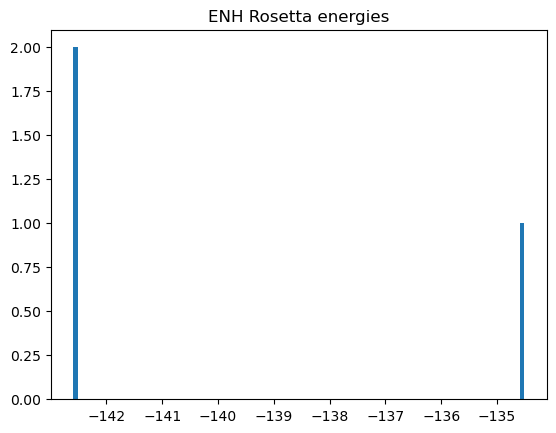

In [5]:
plt.hist(enh_energies, bins=100)
plt.title("ENH Rosetta energies")

In [64]:
min(enh_energies)

-138.5436888766882

At best it is -138. That is good. Let's look at some of these extreme unstable ones

In [65]:
np.max(enh_energies)

94.39344438123835

In [66]:
enh_og_files[np.argmax(enh_energies)]

'../scripts/proof_of_principle/tmp/af_dg/enh/ensemble_replicate_6.pdb'

original alphafold structure

In [67]:
enh1_og_high_e = parser.get_structure('1enh_high_e_og', enh_og_files[np.argmax(enh_energies)])

In [68]:
nv.show_biopython(enh1_og_high_e, gui=True)

NGLWidget()

Rosetta minimized one.

In [69]:
enh1_ros_high_e_name = os.path.basename(enh_og_files[np.argmax(enh_energies)])
enh1_ros_high_e_name = os.path.join('./tmp/rosetta/enh', enh1_ros_high_e_name)
enh1_ros_high_e = parser.get_structure('1enh_high_e_og', enh1_ros_high_e_name)

/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record '# All ' at line 1036
  warnings.warn(
/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record '#BEGIN' at line 1037
  warnings.warn(
/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'label ' at line 1038
  warnings.warn(
/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'weight' at line 1039
  warnings.warn(
/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unre

In [70]:
nv.show_biopython(enh1_ros_high_e, gui=True)

NGLWidget()

it looks fine... evaluate with the rosettta enery function to confirm.

In [83]:
import pyrosetta
import pyrosetta.io as io

In [80]:
enh1_ros_high_e_name

'./tmp/rosetta/enh/ensemble_replicate_6.pdb'

In [79]:
pyrosetta.init()
energy_fn = pyrosetta.create_score_function('ref2015')

PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python39.ubuntu 2023.27+release.e3ce6ea9faf661ae8fa769511e2a9b8596417e58 2023-07-07T12:00:46] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.ubuntu r353 2023.27+release.e3ce6ea9faf e3ce6ea9faf661ae8fa769511e2a9b8596417e58 http://www.pyrosetta.org 2023-07-07T12:00:46
core.init: command: PyRosetta -ex1 -ex2aro -database /mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/pyrosetta-2023.27+release.e3ce6ea9faf-py3.9-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1283179052 seed_offset=0 real_seed=1283179052
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1283179052 RG_type=mt19937


In [85]:
pose = io.pose_from_pdb(enh1_ros_high_e_name)

core.import_pose.import_pose: File './tmp/rosetta/enh/ensemble_replicate_6.pdb' automatically determined to be of type PDB


In [86]:
energy_fn(pose)

basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/pyrosetta-2023.27+release.e3ce6ea9faf-py3.9-linux-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/pyrosetta-2023.27+release.e3ce6ea9faf-py3.9-linux-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.215872 

94.66268071974972

In [89]:
nomelt.thermo_estimation.rosetta.minimize_structures([enh1_ros_high_e_name])

core.import_pose.import_pose: File './tmp/rosetta/enh/ensemble_replicate_6.pdb' automatically determined to be of type PDB


[-131.17803149375334]

A second minimization run fixes it. How can we run the minimizer to be consistant?

In [92]:
pars = nomelt.thermo_estimation.rosetta.RosettaMinimizationParameters(
    tolerance=0.001
)
nomelt.thermo_estimation.rosetta.minimize_structures([enh_og_files[np.argmax(enh_energies)]], params=pars)

core.import_pose.import_pose: File '../scripts/proof_of_principle/tmp/af_dg/enh/ensemble_replicate_6.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 58


[94.39344438123835]

In [93]:
pars = nomelt.thermo_estimation.rosetta.RosettaMinimizationParameters(
    tolerance=0.01
)
nomelt.thermo_estimation.rosetta.minimize_structures([enh_og_files[np.argmax(enh_energies)]], params=pars)

core.import_pose.import_pose: File '../scripts/proof_of_principle/tmp/af_dg/enh/ensemble_replicate_6.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 58


[-111.58235642935594]

In [94]:
pars = nomelt.thermo_estimation.rosetta.RosettaMinimizationParameters(
    tolerance=0.0001
)
nomelt.thermo_estimation.rosetta.minimize_structures([enh_og_files[np.argmax(enh_energies)]], params=pars)

core.import_pose.import_pose: File '../scripts/proof_of_principle/tmp/af_dg/enh/ensemble_replicate_6.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 58


[82.94998065594373]

In [95]:
pars = nomelt.thermo_estimation.rosetta.RosettaMinimizationParameters(
    tolerance=0.00001
)
nomelt.thermo_estimation.rosetta.minimize_structures([enh_og_files[np.argmax(enh_energies)]], params=pars)

core.import_pose.import_pose: File '../scripts/proof_of_principle/tmp/af_dg/enh/ensemble_replicate_6.pdb' automatically determined to be of type PDB
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LYS:CtermProteinFull 58


[62.9285373972017]

If we just stick with the correct tolerance but minimize twice a few times, does it fix it?